In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

In [2]:
data_dir = "./data"
symbol = "API3USDT"
start_date = "2025-10-11"
end_date = "2025-10-16"
interval = "1m"
funding_file_name = f"{symbol}_{start_date}_{end_date}.csv"
file_name = f"{symbol}_{start_date}_{end_date}_{interval}.csv"

In [3]:
# 资金费率数据目录
binance_funding_data_dir = os.path.join(data_dir, "binance", "funding_rate")
bybit_funding_data_dir = os.path.join(data_dir, "bybit", "funding_rate")
# 价格数据目录
binance_price_data_dir = os.path.join(data_dir, "binance", "price")
bybit_price_data_dir = os.path.join(data_dir, "bybit", "price")
# 价格指数数据目录
binance_index_data_dir = os.path.join(data_dir, "binance", "price_index")
bybit_index_data_dir = os.path.join(data_dir, "bybit", "price_index")
# 溢价指数数据目录
binance_premium_data_dir = os.path.join(data_dir, "binance", "premium_index")
bybit_premium_data_dir = os.path.join(data_dir, "bybit", "premium_index")

In [4]:
# 读取资金费率数据
binance_funding_data_df = pd.read_csv(os.path.join(binance_funding_data_dir, funding_file_name))
bybit_funding_data_df = pd.read_csv(os.path.join(bybit_funding_data_dir, funding_file_name))
# 读取价格数据
binance_price_data_df = pd.read_csv(os.path.join(binance_price_data_dir, file_name))
bybit_price_data_df = pd.read_csv(os.path.join(bybit_price_data_dir, file_name))
# 读取价格指数数据
binance_index_data_df = pd.read_csv(os.path.join(binance_index_data_dir, file_name))
bybit_index_data_df = pd.read_csv(os.path.join(bybit_index_data_dir, file_name))
# 读取溢价指数数据
binance_premium_data_df = pd.read_csv(os.path.join(binance_premium_data_dir, file_name))
bybit_premium_data_df = pd.read_csv(os.path.join(bybit_premium_data_dir, file_name))

In [5]:
# 对于funding文件，需要的列有：fundingTime, fundingRate
# 对于price文件，需要的列有：open_time, close并将close列重命名为price
# 对于index_price文件，需要的列有：open_time, close并将close列重命名为index_price
# 对于premium_index文件，需要的列有：open_time, close并将close列重命名为premium_index
binance_funding_data_df = binance_funding_data_df[["fundingTime", "fundingRate"]]
bybit_funding_data_df = bybit_funding_data_df[["fundingTime", "fundingRate"]]
binance_price_data_df = binance_price_data_df[["open_time", "close"]].rename(columns={"close": "price"})
bybit_price_data_df = bybit_price_data_df[["open_time", "close"]].rename(columns={"close": "price"})
binance_index_data_df = binance_index_data_df[["open_time", "close"]].rename(columns={"close": "index_price"})
bybit_index_data_df = bybit_index_data_df[["open_time", "close"]].rename(columns={"close": "index_price"})
binance_premium_data_df = binance_premium_data_df[["open_time", "close"]].rename(columns={"close": "premium_index"})
bybit_premium_data_df = bybit_premium_data_df[["open_time", "close"]].rename(columns={"close": "premium_index"})

In [6]:
# 计算funding interval,使用当前fundingTime与下一个fundingTime的差值
# 将fundingTime转换为datetime格式
binance_funding_data_df["fundingTime"] = pd.to_datetime(binance_funding_data_df["fundingTime"])
bybit_funding_data_df["fundingTime"] = pd.to_datetime(bybit_funding_data_df["fundingTime"])
binance_funding_data_df["funding_interval"] = ((binance_funding_data_df["fundingTime"].shift(-1) - binance_funding_data_df["fundingTime"]).dt.total_seconds() / 60 / 60)
binance_funding_data_df.dropna(inplace=True)
bybit_funding_data_df["funding_interval"] = ((bybit_funding_data_df["fundingTime"].shift(-1) - bybit_funding_data_df["fundingTime"]).dt.total_seconds() / 60 / 60)
bybit_funding_data_df.dropna(inplace=True)

### 绘制计算持有的funding收益
1. 计算funding_profit，使用公式：funding_profit = - binance_funding + bybit_funding
2. 计算funding_profit的累计收益
3. 绘制funding_profit的累计收益曲线

In [7]:
# 按 fundingTime 合并两个交易所的资金费率数据
funding_df = binance_funding_data_df.merge(
  bybit_funding_data_df, on="fundingTime", how="outer", suffixes=("_binance", "_bybit")
).sort_values("fundingTime").reset_index(drop=True)

# 先将 fundingTime 转换为 datetime 类型
funding_df["fundingTime"] = pd.to_datetime(funding_df["fundingTime"])

# 直接使用 pandas 的日期过滤,避免时区问题
start_dt = pd.to_datetime(start_date)
end_dt = pd.to_datetime(end_date) + pd.Timedelta(days=1) - pd.Timedelta(milliseconds=1)

# 过滤数据
funding_df = funding_df[(funding_df["fundingTime"] >= start_dt) & 
                        (funding_df["fundingTime"] <= end_dt)].reset_index(drop=True)
funding_df

,fundingTime,fundingRate_binance,funding_interval_binance,fundingRate_bybit,funding_interval_bybit
0,2025-10-11 00:00:00,-0.005782,4.0,-0.003276,1.0
1,2025-10-11 01:00:00,NaN,NaN,-0.000950,1.0
2,2025-10-11 02:00:00,NaN,NaN,-0.001586,1.0
3,2025-10-11 03:00:00,NaN,NaN,-0.000785,1.0
4,2025-10-11 04:00:00,-0.001886,4.0,-0.000246,1.0
...,...,...,...,...,...
93,2025-10-14 21:00:00,NaN,NaN,-0.000239,1.0
94,2025-10-14 22:00:00,NaN,NaN,-0.000923,1.0
95,2025-10-14 23:00:00,NaN,NaN,-0.000871,1.0
96,2025-10-15 00:00:00,NaN,NaN,-0.001106,1.0


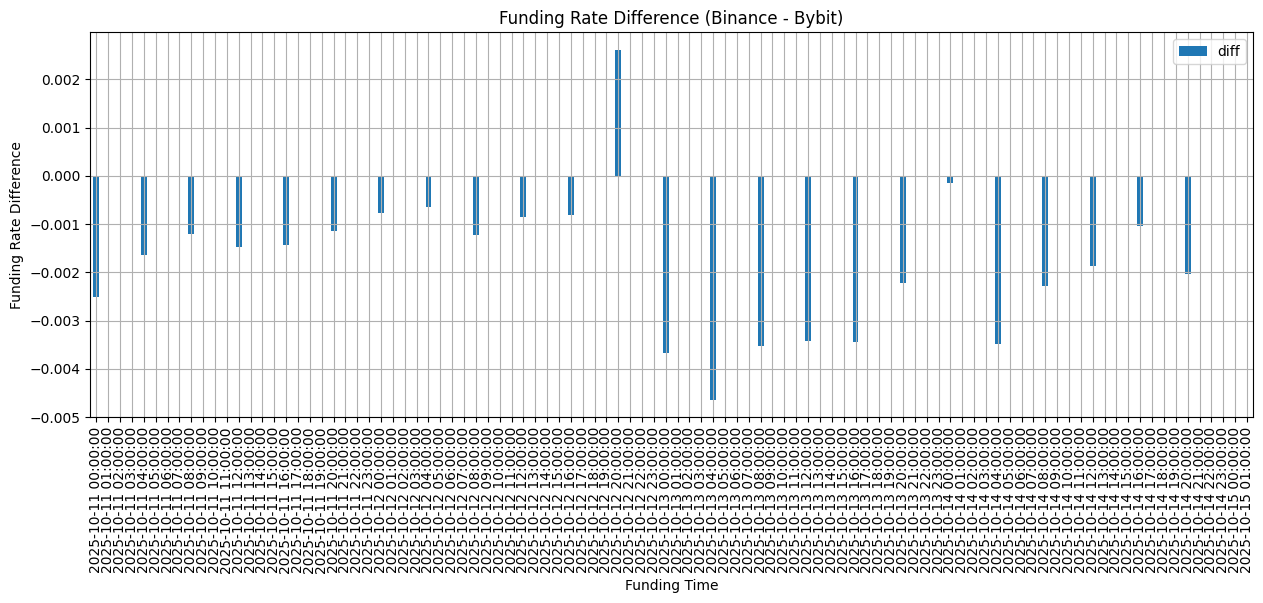

In [8]:
funding_df["diff"] = funding_df["fundingRate_binance"] - funding_df["fundingRate_bybit"]
funding_df.plot(x="fundingTime", y="diff", kind="bar", figsize=(15, 5), title="Funding Rate Difference (Binance - Bybit)")
plt.xlabel("Funding Time")
plt.ylabel("Funding Rate Difference")
plt.grid()
plt.show()

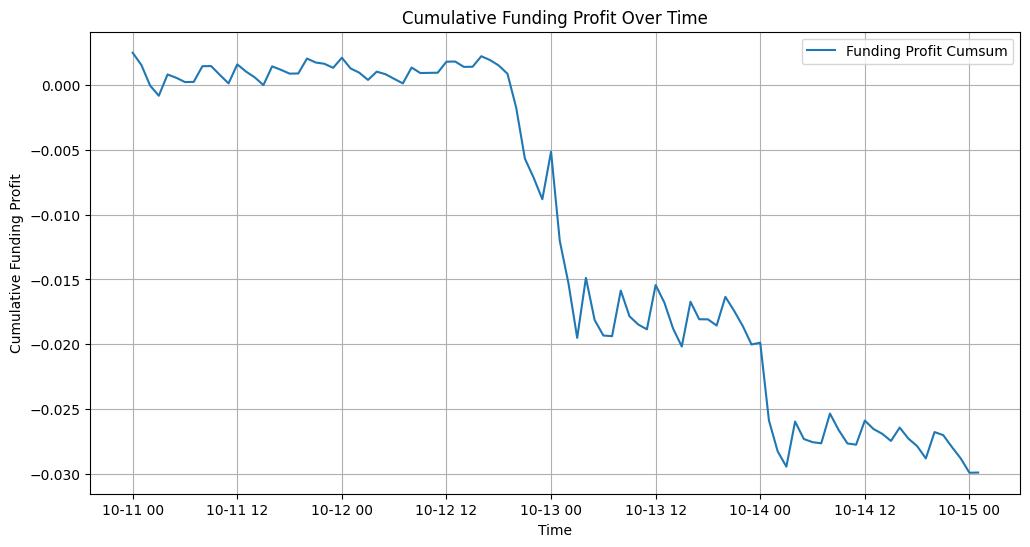

In [9]:
# 使用0填充缺失值
funding_df = funding_df.fillna(0)
# 计算 funding_profit
funding_df["funding_profit"] = -funding_df["fundingRate_binance"] + funding_df["fundingRate_bybit"]
# 计算 funding_profit 的累计收益
funding_df["funding_profit_cumsum"] = funding_df["funding_profit"].cumsum()
# 将 fundingTime 转换为 datetime 格式
if funding_df["fundingTime"].dtype == np.int64 or funding_df["fundingTime"].dtype == np.float64:
  funding_df["fundingTime"] = pd.to_datetime(funding_df["fundingTime"], unit="ms")
elif funding_df["fundingTime"].dtype == object:
  funding_df["fundingTime"] = pd.to_datetime(funding_df["fundingTime"])
# 绘制 funding_profit 的累计收益曲线
plt.figure(figsize=(12, 6))
plt.plot(funding_df["fundingTime"], funding_df["funding_profit_cumsum"], label="Funding Profit Cumsum")
plt.xlabel("Time")
plt.ylabel("Cumulative Funding Profit")
plt.title("Cumulative Funding Profit Over Time")
plt.legend()
plt.grid()
plt.show()

In [10]:
# 合并文件
# 先将价格，指数，溢价指数文件按open_time合并
binance_merged_df = binance_price_data_df.merge(binance_index_data_df, on="open_time").merge(binance_premium_data_df, on="open_time")
# 先将open_time转换为datetime类型，并按时间排序
binance_merged_df["open_time"] = pd.to_datetime(binance_merged_df["open_time"], unit='ms')
binance_merged_df = binance_merged_df.sort_values("open_time")
# 合并资金费率文件
binance_funding_data_df["fundingTime"] = pd.to_datetime(binance_funding_data_df["fundingTime"])
binance_merged_df = binance_merged_df.merge(binance_funding_data_df, left_on="open_time", right_on="fundingTime", how="left")
# 将fundingTime与fundingRate列向上移动1行
binance_merged_df["fundingTime"] = binance_merged_df["fundingTime"].shift(-1)
binance_merged_df["fundingRate"] = binance_merged_df["fundingRate"].shift(-1)
# 使用下一行的fundingTime与fundingRate填充当前行的NaN值，向后填充
binance_merged_df["fundingTime"] = binance_merged_df["fundingTime"].bfill()
binance_merged_df["fundingRate"] = binance_merged_df["fundingRate"].bfill()
# 向前填充interval
binance_merged_df["funding_interval"] = binance_merged_df["funding_interval"].ffill()
binance_merged_df


,open_time,price,index_price,premium_index,fundingTime,fundingRate,funding_interval
0,2025-10-11 00:00:00,0.6363,0.642946,-0.010185,2025-10-11 04:00:00,-0.001886,4.0
1,2025-10-11 00:01:00,0.6336,0.639589,-0.008767,2025-10-11 04:00:00,-0.001886,4.0
2,2025-10-11 00:02:00,0.6370,0.641922,-0.007463,2025-10-11 04:00:00,-0.001886,4.0
3,2025-10-11 00:03:00,0.6377,0.642675,-0.005619,2025-10-11 04:00:00,-0.001886,4.0
4,2025-10-11 00:04:00,0.6359,0.642604,-0.008986,2025-10-11 04:00:00,-0.001886,4.0
...,...,...,...,...,...,...,...
5887,2025-10-15 02:07:00,0.7075,0.709963,-0.002980,NaT,NaN,4.0
5888,2025-10-15 02:08:00,0.7078,0.710527,-0.003195,NaT,NaN,4.0
5889,2025-10-15 02:09:00,0.7076,0.710293,-0.003273,NaT,NaN,4.0
5890,2025-10-15 02:10:00,0.7081,0.710418,-0.002567,NaT,NaN,4.0


In [11]:
bybit_merged_df = bybit_price_data_df.merge(bybit_index_data_df, on="open_time").merge(bybit_premium_data_df, on="open_time")
# 先将open_time转换为datetime类型，并按时间排序
bybit_merged_df["open_time"] = pd.to_datetime(bybit_merged_df["open_time"], unit='ms')
bybit_merged_df = bybit_merged_df.sort_values("open_time")
# 合并资金费率文件
bybit_funding_data_df["fundingTime"] = pd.to_datetime(bybit_funding_data_df["fundingTime"])
bybit_merged_df = bybit_merged_df.merge(bybit_funding_data_df, left_on="open_time", right_on="fundingTime", how="left")
# 将fundingTime与fundingRate列向上移动1行
bybit_merged_df["fundingTime"] = bybit_merged_df["fundingTime"].shift(-1)
bybit_merged_df["fundingRate"] = bybit_merged_df["fundingRate"].shift(-1)
# 使用下一行的fundingTime与fundingRate填充当前行的NaN值，向后填充
bybit_merged_df["fundingTime"] = bybit_merged_df["fundingTime"].bfill()
bybit_merged_df["fundingRate"] = bybit_merged_df["fundingRate"].bfill()
# 向前填充interval
bybit_merged_df["funding_interval"] = bybit_merged_df["funding_interval"].ffill()
bybit_merged_df

,open_time,price,index_price,premium_index,fundingTime,fundingRate,funding_interval
0,2025-10-11 00:00:00,0.6396,0.6418,-0.001570,2025-10-11 01:00:00,-0.00095,1.0
1,2025-10-11 00:01:00,0.6369,0.6388,-0.000147,2025-10-11 01:00:00,-0.00095,1.0
2,2025-10-11 00:02:00,0.6396,0.6422,0.000000,2025-10-11 01:00:00,-0.00095,1.0
3,2025-10-11 00:03:00,0.6398,0.6433,-0.000126,2025-10-11 01:00:00,-0.00095,1.0
4,2025-10-11 00:04:00,0.6386,0.6430,-0.001838,2025-10-11 01:00:00,-0.00095,1.0
...,...,...,...,...,...,...,...
5888,2025-10-15 02:08:00,0.7092,0.7104,-0.000237,NaT,NaN,1.0
5889,2025-10-15 02:09:00,0.7091,0.7102,-0.000848,NaT,NaN,1.0
5890,2025-10-15 02:10:00,0.7095,0.7103,-0.000905,NaT,NaN,1.0
5891,2025-10-15 02:11:00,0.7100,0.7106,-0.000413,NaT,NaN,1.0


In [12]:
# 计算资金费率的函数
def clamp(v, lower_bound=-0.0005, upper_bound=0.0005):
    return max(lower_bound, min(upper_bound, v))
def calculate_funding_rate(avg_premium_index, interval, is_new_formula, r=0.0001):
    i = interval / 8 * r
    if is_new_formula:
        funding_rate = (avg_premium_index + clamp(r-avg_premium_index)) / (8/interval)
    else:
        funding_rate = avg_premium_index + clamp(i - avg_premium_index)

    funding_rate = clamp(funding_rate, lower_bound=-0.02, upper_bound=0.02)
    return funding_rate

In [13]:
# 计算实时funding rate
# 先根据相同的fundingTime对数据分组再根据其其各组的序列号赋予权重
binance_merged_df["weight"] = binance_merged_df.groupby("fundingTime").cumcount() + 1
# 计算平均溢价指数
binance_merged_df["premium_index_weighted"] = binance_merged_df["premium_index"] * binance_merged_df["weight"]
binance_merged_df["avg_premium_index"] = binance_merged_df.groupby("fundingTime")["premium_index_weighted"].cumsum() / binance_merged_df.groupby("fundingTime")["weight"].cumsum()
if symbol == "BNBUSDT":
    binance_merged_df["real_time_funding_rate"] = binance_merged_df.apply(lambda row: calculate_funding_rate(row["avg_premium_index"], row["funding_interval"], is_new_formula=True, r=0), axis=1)
else:
    binance_merged_df["real_time_funding_rate"] = binance_merged_df.apply(lambda row: calculate_funding_rate(row["avg_premium_index"], row["funding_interval"], is_new_formula=True), axis=1)

# bybit
bybit_merged_df["weight"] = bybit_merged_df.groupby("fundingTime").cumcount() + 1
# 计算平均溢价指数
bybit_merged_df["premium_index_weighted"] = bybit_merged_df["premium_index"] * bybit_merged_df["weight"]
bybit_merged_df["avg_premium_index"] = bybit_merged_df.groupby("fundingTime")["premium_index_weighted"].cumsum() / bybit_merged_df.groupby("fundingTime")["weight"].cumsum()
bybit_merged_df["real_time_funding_rate"] = bybit_merged_df.apply(lambda row: calculate_funding_rate(row["avg_premium_index"], row["funding_interval"], is_new_formula=False), axis=1)

In [14]:
# 使用open_time合并两个交易所的数据
merged_df = binance_merged_df.merge(bybit_merged_df, on="open_time", suffixes=("_binance", "_bybit"))
# 删除nan值
merged_df = merged_df.dropna()
# 重置索引
merged_df = merged_df.reset_index(drop=True)

In [15]:
merged_df

,open_time,price_binance,index_price_binance,premium_index_binance,fundingTime_binance,fundingRate_binance,funding_interval_binance,weight_binance,premium_index_weighted_binance,avg_premium_index_binance,...,price_bybit,index_price_bybit,premium_index_bybit,fundingTime_bybit,fundingRate_bybit,funding_interval_bybit,weight_bybit,premium_index_weighted_bybit,avg_premium_index_bybit,real_time_funding_rate_bybit
0,2025-10-11 00:00:00,0.6363,0.642946,-0.010185,2025-10-11 04:00:00,-0.001886,4.0,1.0,-0.010185,-0.010185,...,0.6396,0.6418,-0.001570,2025-10-11 01:00:00,-0.000950,1.0,1.0,-0.001570,-0.001570,-0.001070
1,2025-10-11 00:01:00,0.6336,0.639589,-0.008767,2025-10-11 04:00:00,-0.001886,4.0,2.0,-0.017534,-0.009240,...,0.6369,0.6388,-0.000147,2025-10-11 01:00:00,-0.000950,1.0,2.0,-0.000293,-0.000621,-0.000121
2,2025-10-11 00:02:00,0.6370,0.641922,-0.007463,2025-10-11 04:00:00,-0.001886,4.0,3.0,-0.022389,-0.008351,...,0.6396,0.6422,0.000000,2025-10-11 01:00:00,-0.000950,1.0,3.0,0.000000,-0.000311,0.000012
3,2025-10-11 00:03:00,0.6377,0.642675,-0.005619,2025-10-11 04:00:00,-0.001886,4.0,4.0,-0.022477,-0.007258,...,0.6398,0.6433,-0.000126,2025-10-11 01:00:00,-0.000950,1.0,4.0,-0.000505,-0.000237,0.000012
4,2025-10-11 00:04:00,0.6359,0.642604,-0.008986,2025-10-11 04:00:00,-0.001886,4.0,5.0,-0.044931,-0.007834,...,0.6386,0.6430,-0.001838,2025-10-11 01:00:00,-0.000950,1.0,5.0,-0.009191,-0.000771,-0.000271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,2025-10-14 19:55:00,0.7028,0.707482,-0.006764,2025-10-14 20:00:00,-0.002865,4.0,236.0,-1.596417,-0.006251,...,0.7049,0.7072,-0.001847,2025-10-14 20:00:00,-0.000833,1.0,56.0,-0.103430,-0.001250,-0.000750
5516,2025-10-14 19:56:00,0.7022,0.705998,-0.005359,2025-10-14 20:00:00,-0.002865,4.0,237.0,-1.269986,-0.006244,...,0.7039,0.7060,-0.002414,2025-10-14 20:00:00,-0.000833,1.0,57.0,-0.137595,-0.001290,-0.000790
5517,2025-10-14 19:57:00,0.7031,0.706772,-0.004920,2025-10-14 20:00:00,-0.002865,4.0,238.0,-1.170896,-0.006233,...,0.7050,0.7064,-0.001767,2025-10-14 20:00:00,-0.000833,1.0,58.0,-0.102513,-0.001306,-0.000806
5518,2025-10-14 19:58:00,0.7032,0.707288,-0.004640,2025-10-14 20:00:00,-0.002865,4.0,239.0,-1.109013,-0.006220,...,0.7055,0.7069,-0.001108,2025-10-14 20:00:00,-0.000833,1.0,59.0,-0.065366,-0.001300,-0.000800


In [16]:
# merged_df = merged_df[-2*24*60:-24*60]  # 取最近24小时数据
merged_df = merged_df[-32*60:]  # 取最近24小时数据
# merged_df = merged_df[:18*60]  # 取前24小时数据

C:\Users\dl\AppData\Local\Temp\ipykernel_16028\3737944344.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["premium_index_bybit_ma30"] = merged_df["premium_index_bybit"].ewm(span=30).mean()


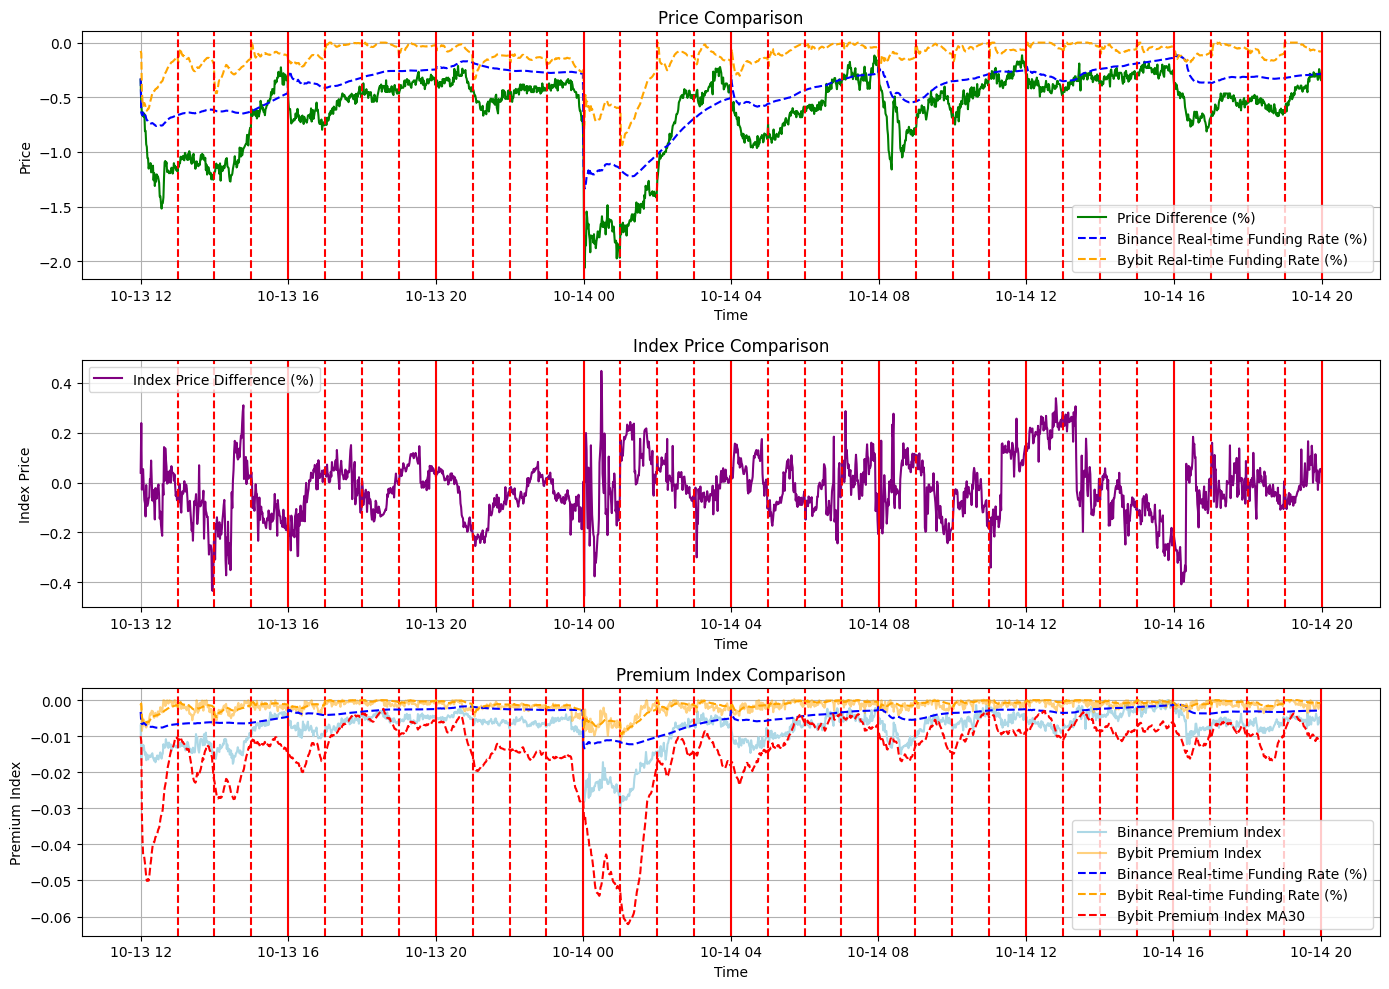

In [17]:
# merged_df = merged_df[-8*60:]  # 取前24小时数据
# 使用三张图片展示价格，指数，溢价指数的对比
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
# plt.plot(merged_df["open_time"], merged_df["price_binance"], label="Binance Price", color="blue")
# plt.plot(merged_df["open_time"], merged_df["price_bybit"], label="Bybit Price", color="orange")
# 绘制百分比
plt.plot(merged_df["open_time"], (merged_df["price_binance"] - merged_df["price_bybit"]) / merged_df["price_bybit"] * 100, label="Price Difference (%)", color="green")
# 添加绘制实时funding rate
plt.plot(merged_df["open_time"], merged_df["real_time_funding_rate_binance"] * 100, label="Binance Real-time Funding Rate (%)", color="blue", linestyle='--')
plt.plot(merged_df["open_time"], merged_df["real_time_funding_rate_bybit"] * 100 * 1, label="Bybit Real-time Funding Rate (%)", color="orange", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Price Comparison")
plt.legend()
plt.grid()
plt.subplot(3, 1, 2)
# plt.plot(merged_df["open_time"], merged_df["index_price_binance"], label="Binance Index Price", color="blue")
# plt.plot(merged_df["open_time"], merged_df["index_price_bybit"], label="Bybit Index Price", color="orange")
# 绘制百分比
plt.plot(merged_df["open_time"], (merged_df["index_price_binance"] - merged_df["index_price_bybit"]) / merged_df["index_price_bybit"] * 100, label="Index Price Difference (%)", color="purple")
plt.xlabel("Time")
plt.ylabel("Index Price")
plt.title("Index Price Comparison")
plt.legend()
plt.grid()
plt.subplot(3, 1, 3)
plt.plot(merged_df["open_time"], merged_df["premium_index_binance"], label="Binance Premium Index", color="lightblue")
plt.plot(merged_df["open_time"], merged_df["premium_index_bybit"], label="Bybit Premium Index", color="orange", alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Premium Index")
plt.title("Premium Index Comparison")
plt.legend()
plt.grid()

# 在每一张图上绘制fundingTime
# 其中如果只有只有一个交易所有进行结算时，使用红色虚线
# 如果两个交易所都有进行结算时，使用红色实线
binance_funding_times = merged_df["fundingTime_binance"].dropna().unique()
bybit_funding_times = merged_df["fundingTime_bybit"].dropna().unique()
all_funding_times = sorted(set(binance_funding_times) | set(bybit_funding_times))
for ft in all_funding_times:
    if ft in binance_funding_times and ft in bybit_funding_times:
        plt.subplot(3, 1, 1)
        plt.axvline(x=ft, color='red', linestyle='-')
        plt.subplot(3, 1, 2)
        plt.axvline(x=ft, color='red', linestyle='-')
        plt.subplot(3, 1, 3)
        plt.axvline(x=ft, color='red', linestyle='-')
    else:
        plt.subplot(3, 1, 1)
        plt.axvline(x=ft, color='red', linestyle='--')
        plt.subplot(3, 1, 2)
        plt.axvline(x=ft, color='red', linestyle='--')
        plt.subplot(3, 1, 3)
        plt.axvline(x=ft, color='red', linestyle='--')

# 在最后一张图上绘制资金费率
plt.subplot(3, 1, 3)
# # 使用双y轴
# ax2 = plt.gca().twinx()
# ax2.plot(merged_df["open_time"], merged_df["fundingRate_binance"] * 100, label="Binance Funding Rate (%)", color="green", linestyle='--')
# ax2.plot(merged_df["open_time"], merged_df["fundingRate_bybit"] * 100, label="Bybit Funding Rate (%)", color="purple", linestyle='--')
# ax2.set_ylabel("Funding Rate (%)")
# ax2.legend(loc='upper right')
# 使用单y轴
# plt.plot(merged_df["open_time"], merged_df["fundingRate_binance"], label="Binance Funding Rate (%)", color="green", linestyle='--')
# plt.plot(merged_df["open_time"], merged_df["fundingRate_bybit"]*1, label="Bybit Funding Rate (%)", color="purple", linestyle='--')
# plt.legend(loc='lower right')
# 添加绘制实时funding rate
plt.plot(merged_df["open_time"], merged_df["real_time_funding_rate_binance"], label="Binance Real-time Funding Rate (%)", color="blue", linestyle='--')
plt.plot(merged_df["open_time"], merged_df["real_time_funding_rate_bybit"] * 1, label="Bybit Real-time Funding Rate (%)", color="orange", linestyle='--')
plt.legend()

# 绘制30分钟的bybit溢价指数的均线
merged_df["premium_index_bybit_ma30"] = merged_df["premium_index_bybit"].ewm(span=30).mean()
plt.plot(merged_df["open_time"], (merged_df["premium_index_bybit_ma30"]*8).apply(lambda x: clamp(x,-0.16,0.16)), label="Bybit Premium Index MA30", color="red", linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()